In [1]:
import os
import numpy as np
import cv2
from glob import glob
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint

from tensorflow.keras.layers import Conv2D, Activation, BatchNormalization
from tensorflow.keras.layers import UpSampling2D, Input, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras import backend as K
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from efficientnet.tfkeras import EfficientNetB4

In [2]:
print("TensorFlow Version: ", tf.__version__)

TensorFlow Version:  2.6.0


In [3]:
np.random.seed(42)
tf.random.set_seed(42)

In [4]:
IMAGE_SIZE = 128
EPOCHS = 30
BATCH = 8
LR = 1e-4

PATH = "Images/"

In [5]:
def load_data(path, split=0.1):
    images = sorted(glob(os.path.join(path, "US images/*")))
    masks = sorted(glob(os.path.join(path, "Expert mask images/*")))

    total_size = len(images)
    valid_size = int(split * total_size)
    test_size = int(split * total_size)

    train_x, valid_x = train_test_split(images, test_size=valid_size, random_state=42)
    train_y, valid_y = train_test_split(masks, test_size=valid_size, random_state=42)

    train_x, test_x = train_test_split(train_x, test_size=test_size, random_state=42)
    train_y, test_y = train_test_split(train_y, test_size=test_size, random_state=42)

    return (train_x, train_y), (valid_x, valid_y), (test_x, test_y)

In [6]:
def read_image(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (IMAGE_SIZE, IMAGE_SIZE))
    x = x/255.0
    return x

def read_mask(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (IMAGE_SIZE, IMAGE_SIZE))
    x = x/255.0
    x = np.expand_dims(x, axis=-1)
    return x

In [7]:
def tf_parse(x, y):
    def _parse(x, y):
        x = read_image(x)
        y = read_mask(y)
        return x, y

    x, y = tf.numpy_function(_parse, [x, y], [tf.float64, tf.float64])
    x.set_shape([IMAGE_SIZE, IMAGE_SIZE, 3])
    y.set_shape([IMAGE_SIZE, IMAGE_SIZE, 1])
    return x, y

def tf_dataset(x, y, batch=8):
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.map(tf_parse)
    dataset = dataset.batch(batch)
    dataset = dataset.repeat()
    return dataset

In [9]:
(train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_data(PATH)

print("Training data: ", len(train_x))
print("Validation data: ", len(valid_x))
print("Testing data: ", len(test_x))

Training data:  88
Validation data:  11
Testing data:  11


In [10]:
def read_and_rgb(x):
    x = cv2.imread(x)
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
    return x

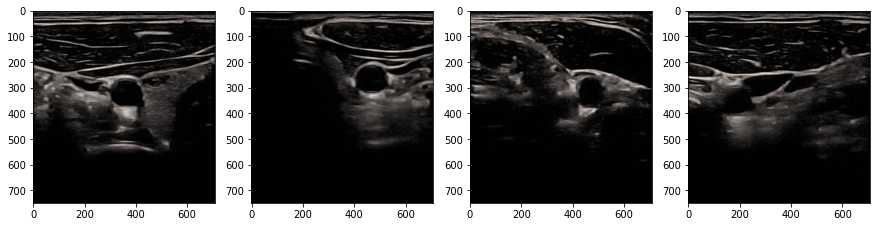

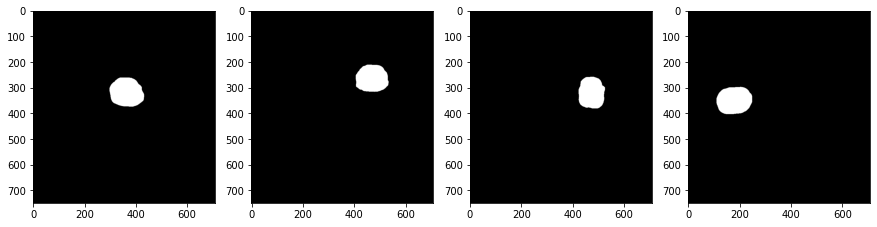

In [11]:
fig = plt.figure(figsize=(15, 15))
a = fig.add_subplot(1, 4, 1)
imgplot = plt.imshow(read_and_rgb(train_x[0]))

a = fig.add_subplot(1, 4, 2)
imgplot = plt.imshow(read_and_rgb(train_x[1]))
imgplot.set_clim(0.0, 0.7)

a = fig.add_subplot(1, 4, 3)
imgplot = plt.imshow(read_and_rgb(train_x[2]))
imgplot.set_clim(0.0, 1.4)

a = fig.add_subplot(1, 4, 4)
imgplot = plt.imshow(read_and_rgb(train_x[3]))
imgplot.set_clim(0.0, 2.1)

fig = plt.figure(figsize=(15, 15))
a = fig.add_subplot(1, 4, 1)
imgplot = plt.imshow(read_and_rgb(train_y[0]))

a = fig.add_subplot(1, 4, 2)
imgplot = plt.imshow(read_and_rgb(train_y[1]))
imgplot.set_clim(0.0, 0.7)

a = fig.add_subplot(1, 4, 3)
imgplot = plt.imshow(read_and_rgb(train_y[2]))
imgplot.set_clim(0.0, 1.4)

a = fig.add_subplot(1, 4, 4)
imgplot = plt.imshow(read_and_rgb(train_y[3]))
imgplot.set_clim(0.0, 1.4)

In [12]:
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.applications import EfficientNetB4

def attention_gate(input_1, input_2, n_filters):
    g1 = Conv2D(n_filters, kernel_size=1, use_bias=False)(input_1)
    x1 = Conv2D(n_filters, kernel_size=1, use_bias=False)(input_2)
    x2 = Conv2D(n_filters, kernel_size=1, use_bias=False)(input_2)
    psi = Add()([g1, x1])
    psi = Activation('relu')(psi)
    psi = Conv2D(1, kernel_size=1, use_bias=False)(psi)
    psi = Activation('sigmoid')(psi)
    x2 = Multiply()([x2, psi])
    return Add()([x1, x2])

def residual_block(inputs, n_filters):
    x = Conv2D(n_filters, kernel_size=3, padding='same', use_bias=False)(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(n_filters, kernel_size=3, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Add()([inputs, x])
    return Activation('relu')(x)

def create_model():
    inputs = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
    base_model = EfficientNetB4(include_top=False, input_tensor=inputs, weights='imagenet')

    skip_connections = [
        base_model.layers[0].name,    # input layer
        'block2a_expand_activation',  # 64
        'block3a_expand_activation',  # 32
        'block4a_expand_activation',  # 16
        'block6a_expand_activation'   # 8
    ]
    
    encoder_output = base_model.get_layer('block7a_expand_activation').output
    
    f = [256, 64, 32, 16, 8]
    x = encoder_output
    
    for i in range(1, len(skip_connections)+1, 1):
        skip_conn = skip_connections[-i]
        skip_tensor = base_model.get_layer(skip_conn).output
        x = UpSampling2D(size=(2, 2))(x)
        x = attention_gate(x, skip_tensor, f[-i])
        x = residual_block(x, f[-i])
    
    x = Conv2D(1, kernel_size=1, activation='sigmoid')(x)
    
    model = Model(inputs, x)
    
    return model

model = create_model()
model.summary()

71696384/71686520 [==============================] - 12s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 128, 128, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 128, 128, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 129, 129, 3)  0           normalization[0][0]              
____________________________

In [13]:
smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

In [14]:
train_dataset = tf_dataset(train_x, train_y, batch=BATCH)
valid_dataset = tf_dataset(valid_x, valid_y, batch=BATCH)

In [15]:
opt = tf.keras.optimizers.Nadam(LR)
metrics = [dice_coef, Recall(), Precision()]
model.compile(loss=dice_loss, optimizer=opt, metrics=metrics)

In [17]:
filepath = 'C:\\Users\\USer\\mp_diff'

In [18]:
checkpoint = ModelCheckpoint(filepath=filepath, 
                             monitor='val_loss',
                             verbose=1, 
                             save_best_only=True,
                             mode='min')

In [19]:
callbacks = [
    checkpoint,
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4),
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=False)
]

In [20]:
train_steps = len(train_x)//BATCH
valid_steps = len(valid_x)//BATCH

if len(train_x) % BATCH != 0:
    train_steps += 1
if len(valid_x) % BATCH != 0:
    valid_steps += 1

model.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=EPOCHS,
    steps_per_epoch=train_steps,
    validation_steps=valid_steps,
    callbacks=callbacks
) 

Epoch 1/30
11/11 [==============================] - 302s 17s/step - loss: 0.9346 - dice_coef: 0.0654 - recall: 0.5077 - precision: 0.0407 - val_loss: 0.9530 - val_dice_coef: 0.0464 - val_recall: 0.2557 - val_precision: 0.0471

Epoch 00001: val_loss improved from inf to 0.95304, saving model to C:\Users\USer\mp_diff
INFO:tensorflow:Assets written to: C:\Users\USer\mp_diff\assets


C:\Users\USer\anaconda3\envs\tensorflowenv\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/30
11/11 [==============================] - 122s 10s/step - loss: 0.9170 - dice_coef: 0.0830 - recall: 0.4711 - precision: 0.0583 - val_loss: 0.9531 - val_dice_coef: 0.0463 - val_recall: 0.0449 - val_precision: 0.0864

Epoch 00002: val_loss did not improve from 0.95304
Epoch 3/30
11/11 [==============================] - 105s 10s/step - loss: 0.9016 - dice_coef: 0.0984 - recall: 0.4730 - precision: 0.0736 - val_loss: 0.9535 - val_dice_coef: 0.0459 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00

Epoch 00003: val_loss did not improve from 0.95304
Epoch 4/30
11/11 [==============================] - 109s 10s/step - loss: 0.8665 - dice_coef: 0.1335 - recall: 0.5263 - precision: 0.1158 - val_loss: 0.9542 - val_dice_coef: 0.0452 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00

Epoch 00004: val_loss did not improve from 0.95304
Epoch 5/30
11/11 [==============================] - 107s 10s/step - loss: 0.8020 - dice_coef: 0.1980 - recall: 0.5978 - precision: 0.2125 - val_loss: 